word2vec: http://papers.nips.cc/paper/5021-distributed-representations

word2vec tf tutorial: https://www.tensorflow.org/versions/r0.12/tutorials/word2vec/index.html

skip-thought vectors: https://arxiv.org/abs/1506.06726
- dataset used, BookCorpus, is unfortunately allowed for affiliated academic use only: http://yknzhu.wixsite.com/mbweb

### TODO:

read up on NCE, better understand how it works in tf, why/how to implement negative sampling instead

remove infrequent words from vocab: how to deal with unknown words when projecting text?
- should all removed words map to a special 'mystery word' so they can be reconstituted in text as a placeholder?
- probably best to ignore them and leave them unaltered

mapping back to text:
- need to write own tokenizer which will store whitespace and punctuation for later reassembly

uniform sampling of texts is a problem, lengths vary by several orders of magnitude

current subsampling of inputs is slick, but need to also sample targets
- maybe best to do subsampling as a preprocessing step
- another option is to separate by sentence, instead of using a window size. then sample from each sentence conditioned on word frequency in the corpus. No need to distinguish inputs from targets. Could also sample sentences based on length/sum of word weights

[binder](http://docs.mybinder.org/release-notes)

### IDEAS:

char-RNN for embedding: rather than lookup, embedding vectors are final state of RNN run on words with 1-hot character reps/ or character embeddings from lookup
- has it been done?
- good: fewer parameters, possibly
- good: generalization to mis/alternate spellings, compound words
- bad: conceptual and computational complexity
- ugly: RNN still doesn't condition on context, doesn't help with polysemy or phrases

In [9]:
%load_ext autoreload
%autoreload 2

In [10]:
import sys
sys.path.append('../util/')
import libvictor as lv

In [11]:
#python 3
import math, os, re, operator
from collections import defaultdict

import numpy as np
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist,cdist,squareform
import tensorflow as tf
from keras.preprocessing.text import Tokenizer, base_filter

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
%matplotlib inline
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure

from IPython.display import display, clear_output
import ipywidgets as widgets
import traitlets
from tqdm import tqdm_notebook as tqdm

Using TensorFlow backend.


In [12]:
import pickle
def picklewrite(fname, obj):
    with open(fname, 'wb') as outfile:
        pickle.dump(obj, outfile)
def pickleread(fname):
    with open(fname, 'rb') as infile:
        return pickle.load(infile)

In [13]:
s = tf.InteractiveSession()
output_notebook()

Loading BokehJS ...

In [14]:
#text from disk
regex = re.compile('\w*\.txt')
text_dir = '../../../books/feedbooks'
text_files = [os.path.join(text_dir, f) for f in os.listdir(text_dir) if regex.match(f)]
len(text_files)

3485

In [17]:
text_filters = "—¬–…“”'"+base_filter()
print(text_filters)

# print(apply_list('‘love’:  l’amo-\nur', text_filter_fns))

def process_txt(fname, verbose=False):
    #get rid of quotes but not contractions
    dequote = lv.make_re_filter(r'‘|’\W', ' ')
    #repair any words broken across lines that got reified into text
    debreak = lv.make_re_filter(r'(-|—|–)\W+', '')
    #not sure why Š and š are showing up in whitespace of otherwise utf-8 text
    deess = lv.make_re_filter(r'(Š|š)', ' ')
    filter_fn = lv.compose_list([dequote, debreak, deess])
    try:
        with open(fname, "r", encoding='utf8', errors='ignore') as f: #, errors='ignore'
            string = filter_fn(f.read())
            if 'š' in string:
                if verbose: print(fname)
            return string
    except UnicodeDecodeError:
        if verbose: print('{}: falling back to latin_1 encoding'.format(fname))
        with open(fname, "r", encoding='latin1') as f:
            string = f.read()
            string = filter_fn(string)
            return string

—¬–…“”'!"#$%&()*+,-./:;<=>?@[\]^_`{|}~	



In [22]:
# texts = []
# for fname in tqdm(text_files):
#     texts.append(process_txt(fname, True))
texts = (process_txt(fname) for fname in text_files)

In [ ]:
tok = Tokenizer(filters=text_filters)
print('fitting Tokenizer...')
tok.fit_on_texts(texts)
print('saving to disk...')
picklewrite('bin/tokenizer.pickle', tok)
print('done')

fitting Tokenizer...


In [5]:
tok = pickleread('bin/tokenizer.pickle')

In [ ]:
#remove rare words
thresh = 100
tok.word_index = {w:i for w,i in tok.word_index.items() if tok.word_counts[w]>=thresh}

vocab_size = max(tok.word_index.values())+1
word_index = tok.word_index
word_counts = tok.word_counts
index_counts = {i:word_counts[w] for w,i in word_index.items()}
index_words = {v:k for k,v in tok.word_index.items()}

print('{} words in vocabulary'.format(vocab_size))

display_dict = {(k,v):tok.word_counts[k] for k,v in tok.word_index.items()}
sorted(display_dict.items(), key=operator.itemgetter(1), reverse=False)

In [154]:
seqs = []
for t in tqdm(texts):
    seqs.append(tok.texts_to_sequences([t])
picklewrite('bin/seqs.pickle', seqs)

In [7]:
seqs = pickleread('bin/seqs.pickle')

In [8]:
# def sample_cdf(cdf):
#     r = np.random.rand()
#     i = bisect_right(cdf, r)
#     return i

def make_batch_generator(seqs, word_counts, word_index, context_size):
    window_size = 2*context_size+1
    # discard any sequences which are smaller than window size
    seqs = [seq for seq in seqs if len(seq)>=window_size]
    # get word frequencies and convert to sampling distribution
    print('mapping indices to counts')
    index_counts = {i:word_counts[w] for w,i in tqdm(word_index.items())}
    print('precomputing cdfs')
    loc_cdfs = []
    for seq in tqdm(seqs): 
        p = 1/np.vectorize(index_counts.get)(seq)
        p[:context_size]=0 # ends of sequences can't be selected as window centers
        p[-context_size:]=0
        p/=p.sum() #normalize so p is a pmf
        p.cumsum(out=p)
        loc_cdfs.append(p)     
    def batch_generator(
        batch_size, n_batches,
        weight_targets_by_frequency=True,
        weight_texts_by_length=False, #slow, should replace multinomal sampling w/ repeated cdf sampling
        method='skipgram',
        seed=None):
        if not seed is None:
            np.random.seed(seed) 
        for _ in range(n_batches):
            # first choose sequences with multinomial distribution
            if weight_texts_by_length:
                seq_n_positions = np.array([len(seq)-window_size+1 for seq in seqs])
                seq_probs = seq_n_positions/seq_n_positions.sum()
                seq_counts = np.random.multinomial(batch_size, seq_probs)
                seq_idxs = sum([[i]*c for i,c in enumerate(seq_counts)], [])
            else:
                seq_idxs = np.random.randint(len(seqs), size=batch_size)

            # then choose windows from those sequences
            if weight_targets_by_frequency:
                window_centers = np.array([lv.sample_cdf(loc_cdfs[i]) for i in seq_idxs])
            else:
                window_centers = np.array([np.random.choice(
                            np.arange(context_size, len(seqs[s_idx])-context_size)
                        ) for s_idx in seq_idxs])
            windows = np.stack((
                    seqs[s_idx][w_c-context_size:w_c+context_size+1] for w_c, s_idx in zip(window_centers, seq_idxs)
                ),0)

            # then rearrange windows into input, target pairs
            words = windows[:, context_size]#np.repeat(windows[:, context_size], window_size-1)
            context_idxs = [i for i in range(window_size) if i!=context_size]
            contexts = windows[:,context_idxs]
            if method=='skipgram':
                inputs, targets = words, contexts
            elif method=='cbow':
                inputs, targets = contexts, words
            else:
                raise ValueError('unrecognized method {}'.format(method))
            yield inputs, targets
    return batch_generator

In [32]:
# hyperparameters
embed_size = 256 #dimensionality of embedding
nce_k = 15 #number of NCE samples
learning_rate = 0.001 #optimizer learning rate

In [10]:
context_size = 5 #size of context in either direction: window_size=2*context_size+1

# make the batch generator, which involves substantial preprocessing for large datasets
batch_generator = make_batch_generator(seqs, tok.word_counts, tok.word_index, context_size)

mapping indices to counts

precomputing cdfs



In [33]:
# %%prun
batch_size = 256
n_batches = 512
for inputs, targets in tqdm(batch_generator(batch_size, n_batches)):
#     t = Tokenizer()
#     input_words, target_words = ([index_words[i] for i in batch] for batch in [inputs, targets[:,0]])
#     t.fit_on_texts(input_words)
#     print(sorted(t.word_counts.items(), key=operator.itemgetter(1), reverse=True))
#     t.fit_on_texts(target_words)
#     print(sorted(t.word_counts.items(), key=operator.itemgetter(1), reverse=True))
    pass

In [34]:
s.close()
tf.reset_default_graph()
s = tf.InteractiveSession()

#parameters
embeddings = tf.Variable(tf.random_uniform([vocab_size, embed_size], -1.0, 1.0))
nce_weights = tf.Variable(tf.truncated_normal( # do these define the v' embeddings? why different from the input embeddings?
        [vocab_size, embed_size],
        stddev=1.0 / np.sqrt(embed_size)
    ))
nce_biases = tf.Variable(tf.zeros([vocab_size]))

#inputs
train_inputs = tf.placeholder(tf.int32, shape=[None]) #input word as integer
train_targets = tf.placeholder(tf.int32, shape=[None, context_size*2]) #target words as integers

#embed inputs
embed = tf.nn.embedding_lookup(embeddings, train_inputs)

# NCE loss
# this is sampling negative labels from within the batch?
loss = tf.reduce_mean(tf.nn.nce_loss(
        nce_weights, nce_biases, embed, train_targets, nce_k, vocab_size, context_size*2
    ))

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

init_op = tf.initialize_all_variables()

In [35]:
epoch_idxs = []
losses = []

def init_train():
    elapsed_batches = 0
    s.run(init_op)
    #set up bokeh plot
    p = figure(title='train loss', plot_height=400, plot_width=600)
    p.scatter(x=epoch_idxs, y=losses, radius=1, fill_alpha=0.3)
    return show(p, notebook_handle=True)

def train(n_batches, batch_size=256, epoch_size=30):
    epoch_losses = []
    batch_idx = 0
    for inputs, targets in tqdm(batch_generator(batch_size, n_batches)):
        feed_dict = {train_inputs: inputs, train_targets: targets}
        _, cur_loss = s.run([optimizer, loss], feed_dict=feed_dict)
        epoch_losses.append(cur_loss)
        batch_idx+=1
        if batch_idx == epoch_size:
            losses.append(np.mean(epoch_losses))
            epoch_idxs.append(len(epoch_idxs))
            push_notebook(handle=handle)
            batch_idx = 0
            epoch_losses = []
            
handle = init_train()

In [36]:
train(12000)

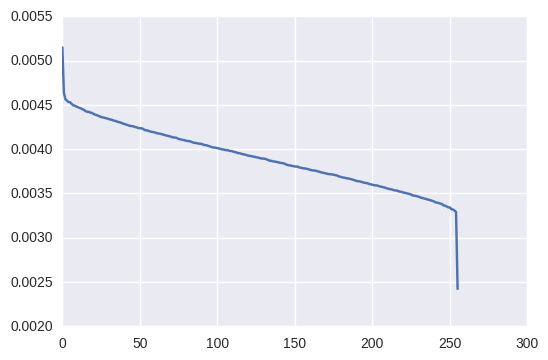

In [37]:
index_embeddings = s.run(embeddings)
word_embeddings = {index_words[i]:e for i,e in enumerate(index_embeddings) if i in index_words}
estimator = PCA()
index_embeddings_pca = estimator.fit_transform(index_embeddings) 
word_embeddings_pca = {index_words[i]:e for i,e in enumerate(index_embeddings_pca) if i in index_words}
plt.plot(estimator.explained_variance_ratio_)

In [38]:
def make_embedding_plot():
    colormap = plt.cm.get_cmap("magma")
    bokehpalette = [colors.rgb2hex(m) for m in colormap(np.arange(colormap.N))]
    p = figure(title='word embedding', plot_height=512, plot_width=512, x_range=(0, 16), y_range=(0, 8))
    d = index_embeddings_pca[1].reshape((16,16))
    im = p.image(image=[d],  x=0, y=0, dw=16, dh=8, palette=bokehpalette)
    handle = show(p, notebook_handle=True)
    def plot_index(i=101):
        p.title.text = str(i)
        d = index_embeddings_pca[i].reshape((16,16))
        im.data_source.data['image'] = [d]
        push_notebook(handle=handle)
    return plot_index
update_embedding_plot = make_embedding_plot()

In [39]:
#todo: add text widget to display/set word
slider = widgets.IntSlider(min=1, max=vocab_size, continuous_update=False)    
play = widgets.Play(value=1, min=1, max=vocab_size, interval = 100)
widgets.jslink((play, 'value'), (slider, 'value'))
widgets.HBox([play,widgets.interactive(update_embedding_plot, i=slider)])

In [ ]:
@widgets.interact(w=widgets.Text(),__manual=True)
def plot_word(w='the'):
    plt.imshow(word_embeddings_pca[w].reshape((8,16)), interpolation='nearest')
    plt.grid(False)

my face which at home and even in the vestibule of the university buildings had denoted only a kind of vague regret that i should have to present so important and distinguished an appearance became exchanged for an expression of the most acute nervousness and dejection however i soon picked up again when i perceived sitting at one of the desks a very badly dressed gentleman who though not really old was almost entirely grey he was occupying a seat quite at the back of the hall and a little apart from the rest so i hastened to sit down beside him and then fell to looking at the candidates for examination and to forming conclusions about them many different figures and faces were there to be seen there yet in my opinion they all seemed to divide themselves into three classes first of all there were youths like myself attending for examination in the company of their parents or tutors among such i could see the youngest accompanied by frost and accompanied by his old father all youths of 

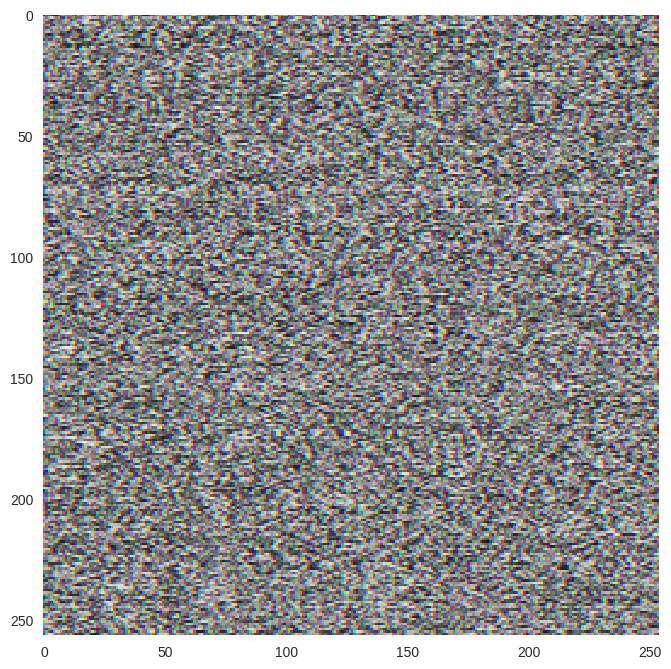

In [41]:
begin = 10000
mean = index_embeddings.mean(0)
def norm(v):
    centered = v-mean
    return centered/np.linalg.norm(centered)
width = 256
seq = seqs[3][begin:begin+width]
print(' '.join(index_words[i] for i in seq))
im = np.stack([norm(index_embeddings[i]) for i in seq],1)
im = np.stack((im[:,:-2], im[:,1:-1], im[:,2:]),2)
fig, ax = plt.subplots(1,1,figsize=(12,8))
ax.imshow((im-im.min())/(im.max()-im.min()), interpolation='nearest')
ax.grid(False)

my face which at home and even in the vestibule of the university buildings had denoted only a kind of vague regret that i should have to present so important and distinguished an appearance became exchanged for an expression of the most acute nervousness and dejection however i soon picked up again when i perceived sitting at one of the desks a very badly dressed gentleman who though not really old was almost entirely grey he was occupying a seat quite at the back of the hall and a little apart from the rest so i hastened to sit down beside him and then fell to looking at the candidates for examination and to forming conclusions about them many different figures and faces were there to be seen


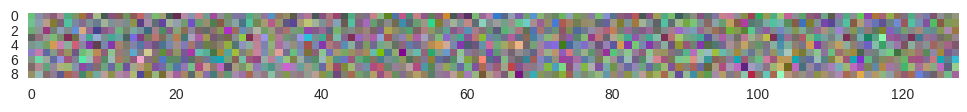

In [42]:
begin = 10000
width = 128
seq = seqs[3][begin:begin+width]
print(' '.join(index_words[i] for i in seq))
im = np.stack([index_embeddings_pca[i] for i in seq],1)
# im = np.stack((im[:,:-2], im[:,1:-1], im[:,2:]),2)
im = im[:int(im.shape[0]/3)*3]
im = np.stack((im[1::3], im[2::3], im[::3]),2)[:9]
fig, ax = plt.subplots(1,1,figsize=(12,5))
ax.imshow((im-im.min())/(im.max()-im.min()), interpolation='nearest')
ax.grid(False)

In [ ]:
# for each word in vocab, compute cosine distance to other words
# store most similar and dissimilar

In [ ]:
#normalize embeddings to unit vectors
index_embeddings/=np.linalg.norm(index_embeddings, axis=1, keepdims=True)
index_nbrs = defaultdict(dict)
for i,v in enumerate(tqdm(index_embeddings[:256])):
    if i==0: continue
    w = index_words[i]
    dists = (v[np.newaxis]*index_embeddings[1:]).sum(1)
    order = np.argsort(dists) #off by one since zero index was skipped
    n = 4
    assert order[-1]+1==i #last with cosine dist of 1 should be identity
    nearest = order[-n-1:-1][::-1]+1
    nearest_words = [index_words[j] for j in nearest]
    nearest_dists = dists[nearest-1]
    furthest = order[:n]+1
    furthest_words = [index_words[j] for j in furthest]
    furthest_dists = dists[furthest-1]
    index_nbrs[w]['nearest'] = [k for k in zip(nearest_words, nearest, nearest_dists)]
    index_nbrs[w]['furthest'] = [k for k in zip(furthest_words, furthest, furthest_dists)]
index_nbrs

### below only good for small vocabulary

In [31]:
np.sum([len(seq) for seq in seqs])

167815336

In [20]:
distances = pdist(index_embeddings, metric='cosine')

In [21]:
#http://stackoverflow.com/questions/13079563/how-does-condensed-distance-matrix-work-pdist
n = index_embeddings.shape[0]
get_distance = lambda i,j: distances[n*j - j*(j+1)/2 + i - 1 - j]
def condensed_to_square(k):
    calc_row_idx = lambda k: np.ceil((1/2.) * (- (-8*k + 4*n**2 - 4*n - 7)**0.5 + 2*n -1) - 1).astype(np.int32)
    elem_in_i_rows = lambda i: i * (n - 1 - i) + (i*(i + 1))/2
    calc_col_idx = lambda k,i: (n - elem_in_i_rows(i + 1) + k).astype(np.int32)
    i = calc_row_idx(k)
    j = calc_col_idx(k,i)
    return i, j

In [22]:
# by_similarity = [condensed_to_square(i) for i in np.argsort(distances)]
by_similarity = np.stack(condensed_to_square(np.argsort(distances)),1)

In [23]:
#remove unused zero word
by_similarity = by_similarity[(by_similarity!=0).all(1)]

In [ ]:
# most similar pairs
c = 0
thresh = 10
num = 32
for i,j in by_similarity:
    if index_counts[i]<thresh or index_counts[j]<thresh:
        continue
    print((index_words[i], index_words[j]))
#     print((index_counts[i], index_counts[j]))
    c+=1
    if c>num:
        break

In [ ]:
#least similar pairs
c = 0
for i,j in by_similarity[::-1]:
    if index_counts[i]<thresh or index_counts[j]<thresh:
        continue
    print((index_words[i], index_words[j]))
    print((index_counts[i], index_counts[j]))
    c+=1
    if c>num:
        break

In [ ]:
s.close()